Наш скрипт работает на LLM моделе GPT(Genetic Pre-trained Transformer). Также мы дополнительно обучили модель, путём более конкретного запроса, а также добавлением в панель управления конкретных фильтров. При запуске без обучения, нами моделью было обработанно 150 постов, языковая модель выдавала ошибочный результат в ~87%.(см. Рис. 1)
При вводе конкретного запроса и обработов 150 постов, языковая модель выдавала ошибочный результат в ~34%.(см. Рис. 2)
При добавлении в панель управления конкретных фильтро и обработов 150 постов, языковая модель выдавала ошибочный результат в ~52%.(см. Рис. 3)
При вводе конкретного запроса и добавлении в панель управления конкретных фильтров, обработав 150 постов, языковая модель выдавала ошибочный результат всего в ~13%.(см. Рис. 4)
Из выше перечисленного можно сделать вывод, что обученая нами модель, выдаёт верный результат в ~87% случаев

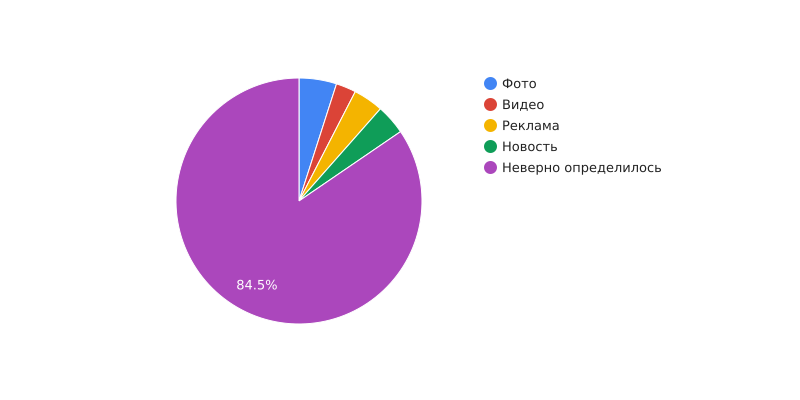

Рис. 1


In [ ]:
from IPython.display import Image, display
display(Image(filename="none.png"))
print('Рис. 1')

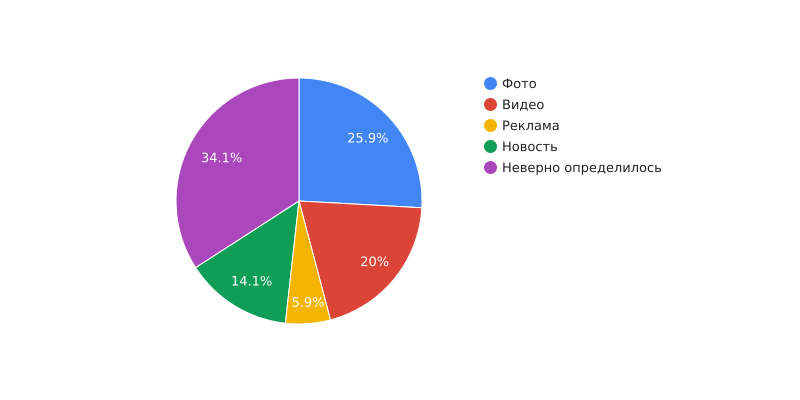

Рис. 2


In [ ]:
from IPython.display import Image, display
display(Image(filename="request.png"))
print('Рис. 2')

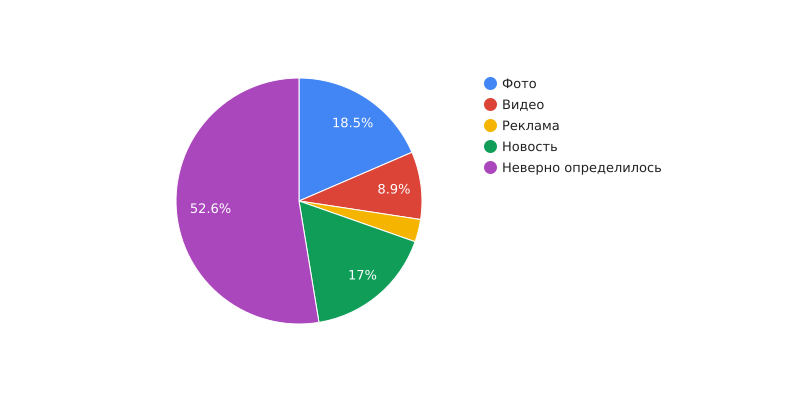

Рис. 4


In [ ]:
from IPython.display import Image, display
display(Image(filename="dashboard.png"))
print('Рис. 3')

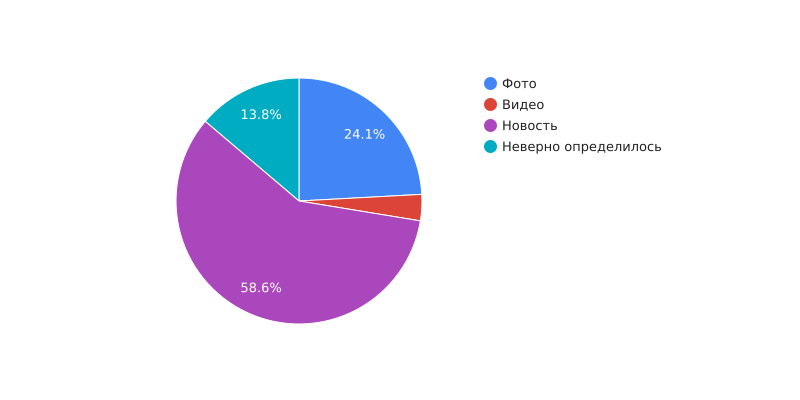

Рис. 4


In [ ]:
from IPython.display import Image, display
display(Image(filename="full.png"))
print('Рис. 4')

Возможными способами улчшения модели скрипта могут быть:

1. Более глубокое обучение языковой модели.
2. Изменение модели с GPT, на ту, которая сделана специальна для классификации постов в ВК.
3. Давать GPT более кокнретные запросы под каждый тип контента
4. Регулярное обновление и переобучение модели на новых данных для улучшения ее точности.
5. Добавление дополнительных признаков или параметров для более точного определения контента

Описание всех шагов решения

1. Изучения информация, знакомство с Jupyter Notebook
2. Обработка получено информации, начало составление кода
3. Сравнение доступных вариантов моделей
4. Изучение информации о получении токена в вк и версии API
5. Изучени методов сбора датасета и его сбор
6. Обучени и тестирование языковой модели
7. Тестирование скрипта и его улучшение
8. Конечные изменение в коде и глобальное тестирование на разных типах контента и получение наилучшего результата

In [ ]:
# Импортируем библиотеки
import os
import requests
import pandas as pd
import openai  # Для использования нейросети
from datetime import datetime
from IPython.display import display  # Для отображения результатов в Jupyter Notebook

# Переменные окружения
TOKEN_USER = os.environ['TOKEN_USER']  # Переменнная окружения для токена профия в ВК
VERSION = '5.199'  # Версия API
DOMAIN = 'public219848506'  # Короткое имя пользователя или сообщества https://vk.com/XXXXXX, где XXXXXX короткое имя пользователя или сообщества
OPENAI_API_KEY = os.environ['OPENAI_API_KEY'] # Переменнная окружения для OpenAI API-ключа
openai.api_key = OPENAI_API_KEY

# Файлы, которые нужно создать и удалить, если они существуют
files_to_remove = ['vk_analysis_notebook.ipynb']

# Удаление старых файлов, если они существуют
for file in files_to_remove:
    if os.path.exists(file):
        os.remove(file)
        print(f"Удален старый файл: {file}")

# Запрашиваем статистику постов со стены через API VK
response = requests.get(
    'https://api.vk.com/method/wall.get',
    params={
        'access_token': TOKEN_USER,
        'v': VERSION,
        'domain': DOMAIN,
        'count': 10, # Количество обрабатываемых постов на стене
        'filter': 'owner'
    }
)

data = response.json().get('response', {}).get('items', [])
display(data)  # Проверка данных

# Функция для определения типа постов с использованием OpenAI
def classify_post_with_openai(text):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",  # Модель нейросети от OpenAI
        messages=[ # Формируем запрос
            {"role": "system", "content": "You are a useful assistant, trained to classify VK posts by category, if there is no text, then use it as a photo or video: мем, новость, реклама, фото, видео, гифка, другое, репост."},
            {"role": "user", "content": f"К какой категории относится следующий текст, фото или видео: '{text}'?"}
        ]
    )
    return response['choices'][0]['message']['content'].strip()

# Считаем категории постов и даты их публикации
post_category_list = []
post_date_list = []
post_link_list = []  # Для хранения ссылок на посты

for post in data:
    post_text = post.get('text', '')
    # Используем OpenAI для классификации текста
    post_category = classify_post_with_openai(post_text)

    # Сохраняем данные поста
    post_category_list.append(post_category)
    post_date_list.append(datetime.fromtimestamp(post['date']))  # Извлечение даты публикации
    post_link_list.append(f"https://vk.com/{DOMAIN}?w=wall{post['from_id']}_{post['id']}")  # Формирование ссылки на пост

# Создаем DataFrame для категорий, дат и ссылок
df_categories = pd.DataFrame({
    'date': post_date_list,
    'category': post_category_list,
    'link': post_link_list
})

display(df_categories)  # Проверка промежуточных данных

# Сохранение данных в Jupyter Notebook
notebook_content = f"""
# Анализ типов постов в VK

## Данные
Данный ноутбук содержит анализ постов со стены ВКонтакте.

### Результаты анализа:
{df_categories.to_markdown(index=False)}
"""

# Запись в файл .ipynb
notebook_filename = 'vk_analysis_notebook.ipynb'
with open(notebook_filename, 'w', encoding='utf-8') as f:
    f.write(notebook_content)

print(f"Данные успешно сохранены в {notebook_filename}")

# Завершение выполнения скрипта
exit()